# Sentiment Classification for IMDB Movie Reviews


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer

## Loading the Data

You will need to load the reviews. These are provided in the zip.
In addition, you will use pretrained embeddings (GloVe, 100d) which you need to download e.g. from https://nlp.stanford.edu/projects/glove/ .

In [2]:
movie_reviews = pd.read_csv("imdb_data/IMDB Dataset.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [3]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<AxesSubplot:xlabel='sentiment', ylabel='count'>

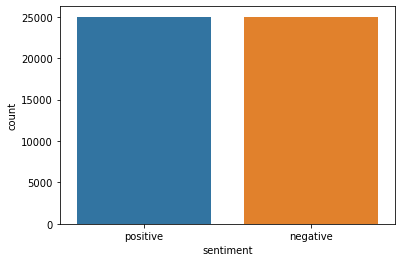

In [5]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)


## Preprocessing

__Prepare the review content__:

Remove 
* html tags
* replace punctuation with a space
* remove single characters
* remove multiple spaces

Split into train/test.

Tokenize the reviews - i.e. mapping the words to integers by using a vocabulary of the most frequent words.

Cut and pad the sequences to a given fixed length.

In [6]:
num_words = 5000
maxlen = 100

In [7]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [8]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [9]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Now the above sample review looks as follows - e.g. in teh first sentence, "there's a zombie" is replaced by just "there a zombie"

In [10]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

__Prepare the labels__

In [11]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

__Split into train/test__

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

__Tokenize__

In [13]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
vocab_size = len(tokenizer.word_index) + 1
print("Tokenizer has found %i words. When transforming texts to sequences words that have an index above %i are just ignored."%(vocab_size, num_words))

Tokenizer has found 92547 words. When transforming texts to sequences words that have an index above 5000 are just ignored.


In [15]:
indices = [0,1,2,3,4,5,6,4999,5000,10000]
for word, index in tokenizer.word_index.items():
    if index in indices:
        print("%s : %i"%(word,index))

the : 1
and : 2
of : 3
to : 4
is : 5
it : 6
secretly : 4999
joins : 5000
shattering : 10000


In [16]:
tokenizer.texts_to_sequences(["This is %s."%tokenizer.index_word[10000]])

[[8, 5]]

__Cutting and Padding__

In [17]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Utility

In [18]:
def performance_plots(model, X_test, Y_test, log, epochs):    
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [19]:
import sklearn
import pandas as pd
activities = ["neg", "pos"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.round(scores)
    labels = Y_test
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## A First Simple Model: Just an embedding layer and a dense layer 

In [20]:
# START YOUR CODE

nepochs = 10
embedding_dim = 32
batchsize = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

# END YOUR CODE

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 32)           2961504   
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3201      
Total params: 2,964,705
Trainable params: 2,964,705
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 18s 15ms/step - loss: 0.5450 - accuracy: 0.7056 - val_loss: 0.3096 - val_accuracy: 0.8632
Epoch 2/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.2666 - accuracy: 0.8918 - val_loss: 0.3123 - val_accuracy: 0.8640
Epoch 3/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.1931 - accuracy: 0.9305 - val_loss: 0.3328 - val_accuracy: 0.8553
Epoch 4/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.1153 - accuracy: 0.9710 - val_loss: 0.3679 - val_accuracy: 0.8495
Epoch 5/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0553 - accuracy: 0.9936 - val_loss: 0.4074 - val_accuracy: 0.8437
Epoch 6/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0250 - accuracy: 0.9991 - val_loss: 0.4569 - val_accuracy: 0.8453
Epoch 7/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.0113 - accuracy: 0.9999 - val_loss: 0.5060 -

Train accuracy (end): 1.0
Train accuracy (max): 1.0
Test accuracy (end) : 0.8443999886512756
Test accuracy (max) : 0.8640000224113464


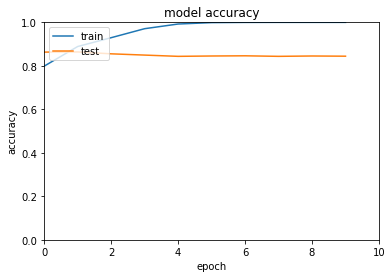

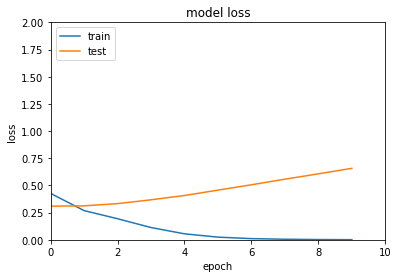

,neg,pos
neg,4154,807
pos,749,4290


In [22]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

We easily get into the overfitting regime since we have a huge amount of parameters.

## Using GloVe as pretrained embedding

In [23]:
embeddings_dictionary = dict()
glove_file = open('./glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [24]:
embedding_matrix = np.zeros((num_words, maxlen))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None and index<num_words:
        embedding_matrix[index] = embedding_vector

In [25]:
# START YOUR CODE
nepochs = 10
embedding_dim = 100
batchsize = 32
embedding_layer = Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# START YOUR CODE

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 510,001
Trainable params: 10,001
Non-trainable params: 500,000
_________________________________________________________________
None


In [26]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 2s 1ms/step - loss: 0.6269 - accuracy: 0.6597 - val_loss: 0.5420 - val_accuracy: 0.7364
Epoch 2/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.4802 - accuracy: 0.7750 - val_loss: 0.6551 - val_accuracy: 0.6948
Epoch 3/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.4494 - accuracy: 0.7924 - val_loss: 0.5962 - val_accuracy: 0.7258
Epoch 4/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.4306 - accuracy: 0.8036 - val_loss: 0.6006 - val_accuracy: 0.7289
Epoch 5/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.4151 - accuracy: 0.8111 - val_loss: 0.5965 - val_accuracy: 0.7302
Epoch 6/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.4171 - accuracy: 0.8106 - val_loss: 0.6244 - val_accuracy: 0.7328
Epoch 7/10
1250/1250 [==============================] - 2s 2ms/step - loss: 0.4023 - accuracy: 0.8207 - val_loss: 0.6128 - val_accuracy:

Train accuracy (end): 0.8131999969482422
Train accuracy (max): 0.8131999969482422
Test accuracy (end) : 0.7307000160217285
Test accuracy (max) : 0.7364000082015991


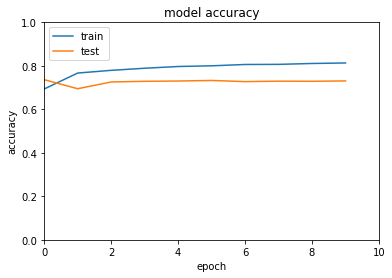

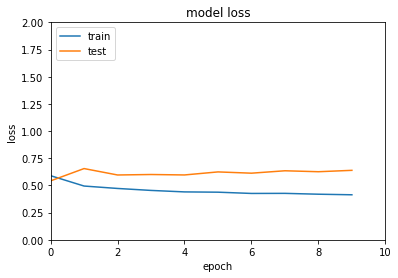

,neg,pos
neg,3640,1321
pos,1372,3667


In [27]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

In [ ]:
model.evaluate(X_test, y_test)

## Further Model / Hyper Parameter Combinations

Examples:

* Pretrained embedding (with GloVe), possibly fine-tuned
* dito + (SimpleRNN | LSTM | GRU | Conv1D)
* dito + stacked layers

For each combination, specify a cell with the model specification, one with the training and one with the evaluation (use for the latter the utilities provided).  


In [42]:
model = Sequential()
model.add(embedding_layer)
model.add(SimpleRNN(32))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# START YOUR CODE

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                4256      
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 504,289
Trainable params: 4,289
Non-trainable params: 500,000
_________________________________________________________________
None


In [43]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 11s 8ms/step - loss: 0.6818 - accuracy: 0.5627 - val_loss: 0.6453 - val_accuracy: 0.6159
Epoch 2/10
1250/1250 [==============================] - 11s 8ms/step - loss: 0.6398 - accuracy: 0.6346 - val_loss: 0.6618 - val_accuracy: 0.5893
Epoch 3/10
1250/1250 [==============================] - 11s 9ms/step - loss: 0.6509 - accuracy: 0.6151 - val_loss: 0.6862 - val_accuracy: 0.5512
Epoch 4/10
1250/1250 [==============================] - 11s 8ms/step - loss: 0.6819 - accuracy: 0.5588 - val_loss: 0.6696 - val_accuracy: 0.5857
Epoch 5/10
1250/1250 [==============================] - 11s 8ms/step - loss: 0.6612 - accuracy: 0.5995 - val_loss: 0.6631 - val_accuracy: 0.6012
Epoch 6/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6663 - accuracy: 0.5882 - val_loss: 0.6638 - val_accuracy: 0.5890
Epoch 7/10
1250/1250 [==============================] - 11s 8ms/step - loss: 0.6518 - accuracy: 0.6132 - val_loss: 0.6632 - val_ac

Train accuracy (end): 0.6292250156402588
Train accuracy (max): 0.6450999975204468
Test accuracy (end) : 0.6585000157356262
Test accuracy (max) : 0.6585000157356262


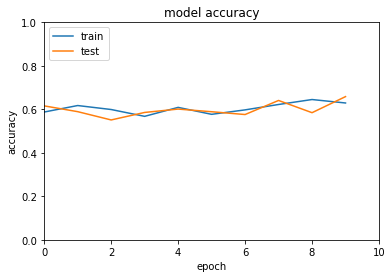

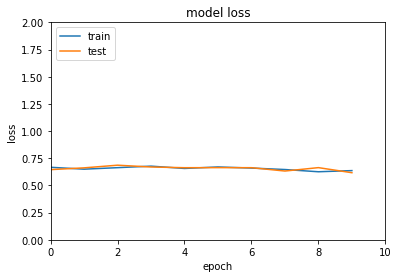

,neg,pos
neg,3676,1285
pos,2130,2909


In [46]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

In [47]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6171 - accuracy: 0.6585


[0.6170698404312134, 0.6585000157356262]

In [54]:
model = Sequential()
model.add(embedding_layer)
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# START YOUR CODE

print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 100, 32)           4256      
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
flatten_8 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 506,369
Trainable params: 6,369
Non-trainable params: 500,000
_________________________________________________________________
None


In [55]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6819 - accuracy: 0.5577 - val_loss: 0.6686 - val_accuracy: 0.5862
Epoch 2/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6499 - accuracy: 0.6148 - val_loss: 0.6570 - val_accuracy: 0.6050
Epoch 3/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6563 - accuracy: 0.6034 - val_loss: 0.6269 - val_accuracy: 0.6476
Epoch 4/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6606 - accuracy: 0.6015 - val_loss: 0.6636 - val_accuracy: 0.6015
Epoch 5/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6481 - accuracy: 0.6162 - val_loss: 0.6316 - val_accuracy: 0.6466
Epoch 6/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6420 - accuracy: 0.6306 - val_loss: 0.6277 - val_accuracy: 0.6559
Epoch 7/10
1250/1250 [==============================] - 23s 18ms/step - loss: 0.6396 - accuracy: 0.6394 - val_loss: 0.6855 -

Train accuracy (end): 0.6402249932289124
Train accuracy (max): 0.6439499855041504
Test accuracy (end) : 0.6492999792098999
Test accuracy (max) : 0.6693000197410583


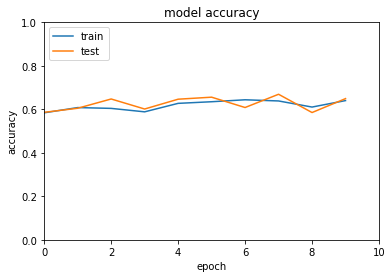

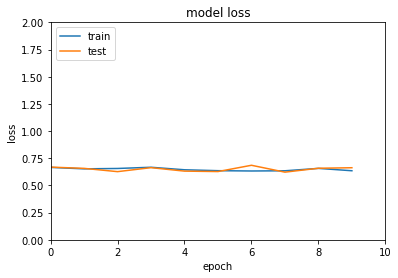

,neg,pos
neg,4161,800
pos,2707,2332


In [56]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

In [57]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.6629 - accuracy: 0.6493


[0.6628775000572205, 0.6492999792098999]

In [61]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(32))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# START YOUR CODE

print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
flatten_11 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 517,057
Trainable params: 17,057
Non-trainable params: 500,000
_________________________________________________________________
None


Epoch 1/10
1250/1250 [==============================] - 20s 15ms/step - loss: 0.5751 - accuracy: 0.6914 - val_loss: 0.4069 - val_accuracy: 0.8167
Epoch 2/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3964 - accuracy: 0.8219 - val_loss: 0.3739 - val_accuracy: 0.8335
Epoch 3/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3611 - accuracy: 0.8402 - val_loss: 0.3676 - val_accuracy: 0.8356
Epoch 4/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3369 - accuracy: 0.8528 - val_loss: 0.3389 - val_accuracy: 0.8489
Epoch 5/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3165 - accuracy: 0.8625 - val_loss: 0.3277 - val_accuracy: 0.8557
Epoch 6/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.3085 - accuracy: 0.8641 - val_loss: 0.3276 - val_accuracy: 0.8546
Epoch 7/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2957 - accuracy: 0.8743 - val_loss: 0.3240 -

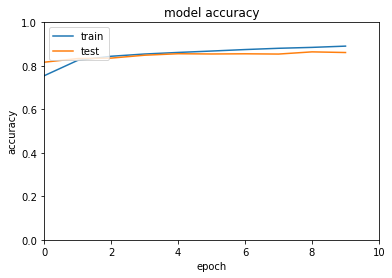

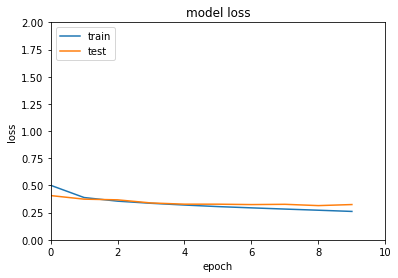

313/313 [==============================] - 2s 7ms/step - loss: 0.3242 - accuracy: 0.8613


[0.32420551776885986, 0.861299991607666]

In [62]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

model.evaluate(X_test, y_test)

In [64]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# START YOUR CODE

print(model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 100, 32)           17024     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 32)           8320      
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
flatten_12 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 533,697
Trainable params: 33,697
Non-trainable params: 500,000
__________________________________________

Epoch 1/10
1250/1250 [==============================] - 57s 44ms/step - loss: 0.5677 - accuracy: 0.6886 - val_loss: 0.4196 - val_accuracy: 0.8086
Epoch 2/10
1250/1250 [==============================] - 54s 43ms/step - loss: 0.3968 - accuracy: 0.8219 - val_loss: 0.3716 - val_accuracy: 0.8326
Epoch 3/10
1250/1250 [==============================] - 54s 43ms/step - loss: 0.3657 - accuracy: 0.8374 - val_loss: 0.3516 - val_accuracy: 0.8400
Epoch 4/10
1250/1250 [==============================] - 54s 44ms/step - loss: 0.3400 - accuracy: 0.8495 - val_loss: 0.3440 - val_accuracy: 0.8480
Epoch 5/10
1250/1250 [==============================] - 54s 43ms/step - loss: 0.3284 - accuracy: 0.8577 - val_loss: 0.3431 - val_accuracy: 0.8472
Epoch 6/10
1250/1250 [==============================] - 54s 44ms/step - loss: 0.3091 - accuracy: 0.8667 - val_loss: 0.3338 - val_accuracy: 0.8522
Epoch 7/10
1250/1250 [==============================] - 54s 44ms/step - loss: 0.3008 - accuracy: 0.8700 - val_loss: 0.3214 -

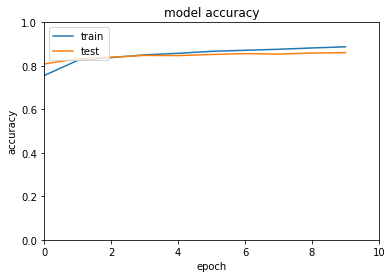

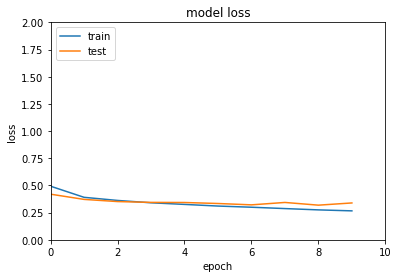

313/313 [==============================] - 5s 15ms/step - loss: 0.3389 - accuracy: 0.8607


[0.33894458413124084, 0.8607000112533569]

In [65]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

model.evaluate(X_test, y_test)

In [68]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(embedding_layer)
model.add(GRU(32))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# START YOUR CODE

print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                12864     
_________________________________________________________________
flatten_14 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 512,897
Trainable params: 12,897
Non-trainable params: 500,000
_________________________________________________________________
None


Epoch 1/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.5676 - accuracy: 0.6775 - val_loss: 0.3730 - val_accuracy: 0.8305
Epoch 2/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3687 - accuracy: 0.8344 - val_loss: 0.3417 - val_accuracy: 0.8448
Epoch 3/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3336 - accuracy: 0.8543 - val_loss: 0.3262 - val_accuracy: 0.8576
Epoch 4/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3145 - accuracy: 0.8623 - val_loss: 0.3209 - val_accuracy: 0.8577
Epoch 5/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3025 - accuracy: 0.8689 - val_loss: 0.3314 - val_accuracy: 0.8566
Epoch 6/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.2910 - accuracy: 0.8757 - val_loss: 0.3293 - val_accuracy: 0.8590
Epoch 7/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.2765 - accuracy: 0.8845 - val_loss: 0.3096 -

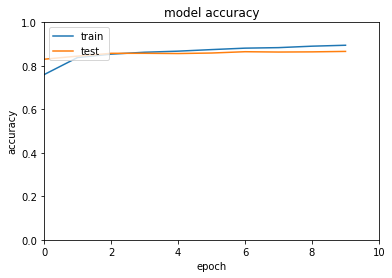

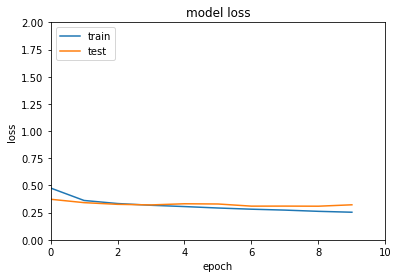

313/313 [==============================] - 1s 5ms/step - loss: 0.3220 - accuracy: 0.8664


[0.3219767212867737, 0.8664000034332275]

In [69]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

model.evaluate(X_test, y_test)

In [70]:
model = Sequential()
model.add(embedding_layer)
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# START YOUR CODE

print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
gru_4 (GRU)                  (None, 100, 32)           12864     
_________________________________________________________________
gru_5 (GRU)                  (None, 100, 32)           6336      
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                6336      
_________________________________________________________________
flatten_15 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 525,569
Trainable params: 25,569
Non-trainable params: 500,000
__________________________________________

Epoch 1/10
1250/1250 [==============================] - 55s 43ms/step - loss: 0.5611 - accuracy: 0.6865 - val_loss: 0.3717 - val_accuracy: 0.8306
Epoch 2/10
1250/1250 [==============================] - 53s 42ms/step - loss: 0.3670 - accuracy: 0.8350 - val_loss: 0.3779 - val_accuracy: 0.8258
Epoch 3/10
1250/1250 [==============================] - 63s 51ms/step - loss: 0.3397 - accuracy: 0.8479 - val_loss: 0.3298 - val_accuracy: 0.8543
Epoch 4/10
1250/1250 [==============================] - 101s 81ms/step - loss: 0.3113 - accuracy: 0.8628 - val_loss: 0.3201 - val_accuracy: 0.8591
Epoch 5/10
1250/1250 [==============================] - 47s 37ms/step - loss: 0.2971 - accuracy: 0.8728 - val_loss: 0.3081 - val_accuracy: 0.8665
Epoch 6/10
1250/1250 [==============================] - 47s 38ms/step - loss: 0.2827 - accuracy: 0.8792 - val_loss: 0.3163 - val_accuracy: 0.8614
Epoch 7/10
1250/1250 [==============================] - 47s 38ms/step - loss: 0.2748 - accuracy: 0.8823 - val_loss: 0.3175 

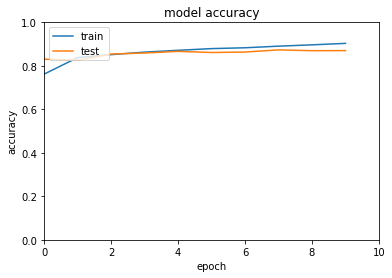

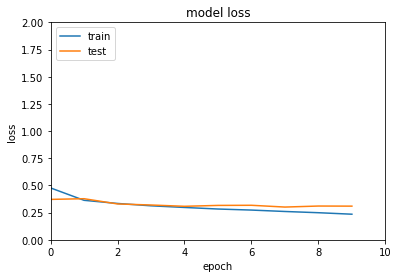

313/313 [==============================] - 3s 11ms/step - loss: 0.3096 - accuracy: 0.8701


[0.30958104133605957, 0.8701000213623047]

In [71]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

model.evaluate(X_test, y_test)

In [72]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(32, 3, activation='relu'))
model.add(Dense(32))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# START YOUR CODE

print(model.summary())

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 32)            9632      
_________________________________________________________________
dense_16 (Dense)             (None, 98, 32)            1056      
_________________________________________________________________
flatten_16 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 3137      
Total params: 513,825
Trainable params: 13,825
Non-trainable params: 500,000
_________________________________________________________________
None


Epoch 1/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5597 - accuracy: 0.6909 - val_loss: 0.3987 - val_accuracy: 0.8181
Epoch 2/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3857 - accuracy: 0.8255 - val_loss: 0.3698 - val_accuracy: 0.8318
Epoch 3/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3495 - accuracy: 0.8426 - val_loss: 0.3665 - val_accuracy: 0.8344
Epoch 4/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.3188 - accuracy: 0.8618 - val_loss: 0.3650 - val_accuracy: 0.8334
Epoch 5/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2943 - accuracy: 0.8765 - val_loss: 0.3682 - val_accuracy: 0.8388
Epoch 6/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2719 - accuracy: 0.8884 - val_loss: 0.3717 - val_accuracy: 0.8362
Epoch 7/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.2533 - accuracy: 0.8965 - val_loss: 0.4236 - val_accuracy:

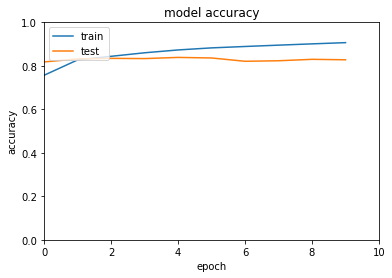

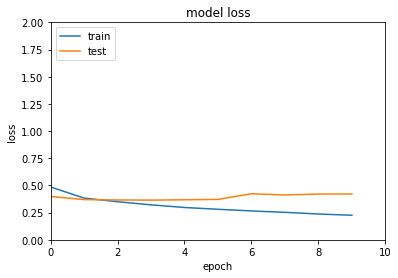

313/313 [==============================] - 0s 1ms/step - loss: 0.4215 - accuracy: 0.8279


[0.42145028710365295, 0.8278999924659729]

In [73]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

model.evaluate(X_test, y_test)

## Report with your Findings

Embedding -> 
SimpleRNN(32) -> 
Train: 64.51%
Test: 65.85%

Embedding -> 
SimpleRNN(32) -> 
SimpleRNN(32) -> 
SimpleRNN(32) -> 
Train: 64.39%
Test: 64.93%

Embedding -> 
LSTM(32) -> 
Train: 89.07%
Test: 86.43%

Embedding -> 
LSTM(32) -> 
LSTM(32) -> 
LSTM(32) -> 
Train: 88.76%
Test: 86.07%

Embedding -> 
GRU(32) -> 
Train: 89.47%
Test: 86.64%

Embedding -> 
GRU(32) -> 
GRU(32) -> 
GRU(32) -> 
Train: 90.34%
Test: 87.34%

Embedding -> 
Conv1D(32,3) -> 
Dense(32) -> 
Train: 90.67%
Test: 83.88%

We found that GRU and stacked GRU layers after the embedding layers have a performance of about 64%, which is the lowest score of our observed models. Using one simple LSTM layer improves the score to 86%. Stacking the LSTM layers on top of each other did not improve the accuracy at all, so we would prefer the simpler one LSTM layer model. A simple one GRU layer model has a similar performance as the one LSTM layer model, but if the GRU layers are stacked on top of each other, the performance improves slightly. One needs to analyse, if the additional complexity is worth the slight improvement.

We ran out of time for further tests, but our next step would be to take the high-bias-low-variance stacked GRU model and play with the number of units and number of layers until we would reach a low bias and low variance as possible. Next, we would add a more complex Conv/Dense/Dropout combination on top, to obtain a nice classifier.